# Keypoint Model Comparison

This notebook benchmarks every trained keypoint model saved in `models/keypoint` against the landmark dataset `data/keypoint.csv` built from MediaPipe hand gestures.

The workflow loads all `.tflite` and `.joblib` checkpoints (others can be added easily) and reports:

- Accuracy, macro F1, per-class precision/recall/F1 and the full classification report.
- Top-k accuracy, inference latency / throughput, disk size, estimated parameter count and training time.
- Robustness to additive landmark noise.
- Confusion matrix visualizations, McNemar's statistical significance test and a focused analysis of the similar gestures **OK (3)**, **Pinch all (7)**, **Pinch small (8)**, and **Love (9)**.

Adjust the configuration cell below if you want to point at a different dataset, tweak the noise magnitude or provide known training times.


*ENSURE all models are trained using the same dataset*

This run was trained and tested on 60K dataset of 10 gestures
* 0 - open - ✋  
* 1 - close - ✊  
* 2 - pointing - 👆  
* 3 - ok - 👌  
* 4 - peace - ✌️  
* 5 - metal - 🤘  
* 6 - thumb - 👍  
* 7 - pinch all - 🤌  
* 8 - pinch small - 🤏  
* 9 - love/heart - 🫰

In [ ]:

import csv
import datetime
import re
import time
from itertools import count
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import joblib
import tensorflow as tf

from scipy.stats import chi2
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_fscore_support,
    top_k_accuracy_score,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

np.set_printoptions(linewidth=140, suppress=True)
pd.set_option("display.max_colwidth", None)

def find_repo_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / "data").is_dir() and (candidate / "models").is_dir():
            return candidate
    raise RuntimeError("Could not locate the project root (data/ and models/ folders not found).")

REPO_ROOT = find_repo_root(Path.cwd())
DATA_FILE = REPO_ROOT / "data" / "keypoint_10gestures_60k.csv"
LABELS_FILE = REPO_ROOT / "data" / "keypoint_labels10gestures_60k.csv"
MODEL_DIR = REPO_ROOT / "models" / "keypoint"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

TOP_K = 3
TOP_K_KEY = f"top_{TOP_K}_accuracy"
NOISE_STD = 0.015
RANDOM_SEED = 42
GESTURE_GROUPS = {
    "Cluster A": [3, 7, 8, 9],  # OK, Pinch All, Pinch Small, Love
    "Cluster B": [2, 4, 5, 6],  # Pointing, Peace, Metal, Thumb
}

# Optional overrides for training time measurements (seconds)
TRAINING_TIME_OVERRIDES = {
    # "joblib::keypoint_classifier_LogisticRegression.joblib": 12.4,
    # "tflite::keypoint_classifier.tflite": 480.0,
}

TRAIN_MODELS = True
TEST_SIZE = 0.25

TRAINED_JOBLIB_MODELS = []
TRAINED_TFLITE_MODELS = []
TRAINING_RUN_RECORDS = []
ARTIFACT_COUNTER = count()

rng = np.random.default_rng(RANDOM_SEED)

JOBLIB_MODELS = []
TFLITE_MODELS = []

print(f"TensorFlow version: {tf.__version__}")
print(f"Repo root: {REPO_ROOT}")
print(f"Dataset: {DATA_FILE}")
print(f"Models directory: {MODEL_DIR}")
print(f"Training enabled: {TRAIN_MODELS}")


TensorFlow version: 2.19.1
Repo root: c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition
Dataset: c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\data\keypoint_10gestures_60k.csv
Models directory: c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\models\keypoint
Training enabled: True


In [2]:
def load_label_map(path: Path):
    mapping = {}
    with path.open(encoding="utf-8-sig") as f:
        reader = csv.reader(f)
        for idx, row in enumerate(reader):
            if not row:
                continue
            raw = row[0].strip()
            digits = "".join(ch for ch in raw if ch.isdigit())
            label_id = int(digits) if digits else idx
            label_name = raw[: len(raw) - len(digits)] or raw
            mapping[label_id] = label_name
    return mapping

label_map = load_label_map(LABELS_FILE)
label_ids_sorted = sorted(label_map.keys())
label_names_sorted = [label_map[i] for i in label_ids_sorted]

df = pd.read_csv(DATA_FILE, header=None)
print(f"Dataset shape: {df.shape} (rows x columns)")
display(df.head())

X = df.iloc[:, 1:].to_numpy(dtype=np.float32)
y = df.iloc[:, 0].astype(int).to_numpy()

X_noise = (X + rng.normal(loc=0.0, scale=NOISE_STD, size=X.shape)).astype(np.float32)

print(f"Feature matrix: {X.shape}, Labels: {y.shape}, Unique classes: {sorted(np.unique(y))}")
print(f"Noise std applied to landmarks: {NOISE_STD}")


Dataset shape: (60559, 43) (rows x columns)


,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,0.0,0.0,0.200787,-0.051181,0.366142,-0.181102,0.484252,-0.307087,0.594488,...,0.039370,-0.976378,-0.074803,-0.429134,-0.145669,-0.578740,-0.185039,-0.685039,-0.220472,-0.787402
1,0,0.0,0.0,0.206349,-0.043651,0.376984,-0.162698,0.507937,-0.273810,0.615079,...,0.047619,-0.980159,-0.079365,-0.428571,-0.142857,-0.583333,-0.182540,-0.690476,-0.210317,-0.793651
2,0,0.0,0.0,0.202381,-0.043651,0.373016,-0.162698,0.500000,-0.277778,0.607143,...,0.039683,-0.980159,-0.083333,-0.428571,-0.146825,-0.579365,-0.186508,-0.686508,-0.214286,-0.789683
3,0,0.0,0.0,0.207171,-0.039841,0.382470,-0.159363,0.509960,-0.274900,0.617530,...,0.051793,-0.980080,-0.079681,-0.426295,-0.143426,-0.581673,-0.183267,-0.689243,-0.211155,-0.792829
4,0,0.0,0.0,0.206349,-0.039683,0.380952,-0.162698,0.507937,-0.281746,0.615079,...,0.051587,-0.980159,-0.079365,-0.428571,-0.142857,-0.583333,-0.178571,-0.690476,-0.210317,-0.793651


Feature matrix: (60559, 42), Labels: (60559,), Unique classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Noise std applied to landmarks: 0.015


In [3]:

NUM_FEATURES = X.shape[1]
FEATURES_PER_LANDMARK = 2
NUM_LANDMARKS = NUM_FEATURES // FEATURES_PER_LANDMARK
NUM_CLASSES = len(label_ids_sorted)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y,
)

print(f"Train split: {X_train_split.shape}, Validation split: {X_val_split.shape}")
print(f"Class distribution (train): {np.bincount(y_train_split, minlength=NUM_CLASSES)}")
print(f"Class distribution (val):   {np.bincount(y_val_split, minlength=NUM_CLASSES)}")


Train split: (45419, 42), Validation split: (15140, 42)
Class distribution (train): [4475 4660 4535 4693 4708 4530 4263 4526 4503 4526]
Class distribution (val):   [1492 1553 1511 1565 1570 1510 1421 1509 1501 1508]



## Unified Training Pipelines

The next cells consolidate the end-to-end training flows from the dedicated notebooks:

- `keypoint_training.ipynb` (MLP baseline)
- `keypoint_training_baseline.ipynb` (classical scikit-learn baselines)
- `keypoint_training_gesture_transformer.ipynb` (graph-aware Transformer)
- `keypoint_training_transformer_self_attention.ipynb` (Transformer self-attention)
- `keypoint_training_xboost.ipynb` (XGBoost)

Running this section retrains every model variant, saves the resulting checkpoints inside `models/keypoint`, and records metrics so the comparison stage can immediately benchmark the fresh outputs.


In [4]:

def slugify_name(name: str) -> str:
    slug = re.sub(r"[^0-9a-zA-Z]+", "_", name).strip("_").lower()
    return slug or "model"

def next_artifact_suffix() -> str:
    return f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{next(ARTIFACT_COUNTER):02d}"

def log_training_record(model_name, artifact_type, artifact_path, train_time, metrics=None):
    record = {
        "model_name": model_name,
        "artifact_type": artifact_type,
        "artifact_path": str(artifact_path),
        "train_time_s": float(train_time),
    }
    if metrics:
        record.update(metrics)
    TRAINING_RUN_RECORDS.append(record)


def register_joblib_model(display_name, alias, estimator, train_time, metrics=None):
    slug = slugify_name(alias or display_name)
    suffix = next_artifact_suffix()
    path = MODEL_DIR / f"keypoint_classifier_{slug}_{suffix}.joblib"
    joblib.dump(estimator, path)
    TRAINED_JOBLIB_MODELS.append(path)
    TRAINING_TIME_OVERRIDES[f"joblib::{path.name}"] = float(train_time)
    log_training_record(display_name, "joblib", path, train_time, metrics)
    return path


def register_tflite_model(display_name, alias, keras_model, train_time, metrics=None, quantize=True):
    slug = slugify_name(alias or display_name)
    suffix = next_artifact_suffix()
    keras_path = MODEL_DIR / f"keypoint_classifier_{slug}_{suffix}.keras"
    keras_model.save(keras_path, include_optimizer=False)

    converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
    if quantize:
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_buffer = converter.convert()

    tflite_path = MODEL_DIR / f"keypoint_classifier_{slug}_{suffix}.tflite"
    with tflite_path.open("wb") as f:
        f.write(tflite_buffer)
    TRAINED_TFLITE_MODELS.append(tflite_path)
    TRAINING_TIME_OVERRIDES[f"tflite::{tflite_path.name}"] = float(train_time)
    log_training_record(display_name, "tflite", tflite_path, train_time, metrics)
    return keras_path, tflite_path


def evaluate_split_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    return acc, macro_f1


def reset_tf_session():
    tf.keras.backend.clear_session()


In [5]:

def train_classical_baselines(X_train, y_train, X_val, y_val):
    print("Training classical ML baselines...")
    models = {
        "LinearSVC": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LinearSVC(
                C=1.0,
                loss="squared_hinge",
                random_state=RANDOM_SEED,
                dual=False,
            )),
        ]),
        "LogisticRegression": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                multi_class="multinomial",
                solver="lbfgs",
                max_iter=1000,
                random_state=RANDOM_SEED,
            )),
        ]),
        "KNeighbors": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", KNeighborsClassifier(
                n_neighbors=5,
                weights="distance",
                metric="minkowski",
            )),
        ]),
        "SVC_RBF": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", SVC(
                kernel="rbf",
                C=10.0,
                gamma="scale",
                probability=True,
                random_state=RANDOM_SEED,
            )),
        ]),
        "RandomForest": RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            random_state=RANDOM_SEED,
            n_jobs=-1,
        ),
    }

    artifacts = []
    for name, estimator in models.items():
        start = time.perf_counter()
        estimator.fit(X_train, y_train)
        duration = time.perf_counter() - start
        y_pred = estimator.predict(X_val)
        acc, macro_f1 = evaluate_split_metrics(y_val, y_pred)
        metrics = {"val_accuracy": acc, "val_macro_f1": macro_f1}
        path = register_joblib_model(f"Baseline::{name}", name, estimator, duration, metrics)
        print(f"  {name:15s} | acc={acc:.4f} macro F1={macro_f1:.4f} | saved→{path.name}")
        artifacts.append((name, path))
    return artifacts


In [6]:

def build_mlp_baseline(input_dim, num_classes):
    return tf.keras.Sequential([
        tf.keras.layers.Input((input_dim,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(20, activation="relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ], name="mlp_keypoint_classifier")


def train_mlp_classifier(X_train, y_train, X_val, y_val):
    print("Training MLP baseline (Keras)...")
    reset_tf_session()
    model = build_mlp_baseline(X_train.shape[1], NUM_CLASSES)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=1)
    ]
    start = time.perf_counter()
    model.fit(
        X_train.astype(np.float32),
        y_train,
        epochs=200,
        batch_size=128,
        validation_data=(X_val.astype(np.float32), y_val),
        callbacks=callbacks,
        verbose=1,
    )
    duration = time.perf_counter() - start
    preds = np.argmax(model.predict(X_val.astype(np.float32), verbose=0), axis=1)
    acc, macro_f1 = evaluate_split_metrics(y_val, preds)
    metrics = {"val_accuracy": acc, "val_macro_f1": macro_f1}
    keras_path, tflite_path = register_tflite_model("MLP", "mlp", model, duration, metrics)
    print(f"  MLP validation accuracy={acc:.4f}, macro F1={macro_f1:.4f} | saved→{tflite_path.name}")
    return keras_path, tflite_path


In [7]:

HAND_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 4),
    (0, 5), (5, 6), (6, 7), (7, 8),
    (0, 9), (9, 10), (10, 11), (11, 12),
    (0, 13), (13, 14), (14, 15), (15, 16),
    (0, 17), (17, 18), (18, 19), (19, 20),
]


def build_adjacency_matrix(num_nodes, connections):
    adj = np.zeros((num_nodes, num_nodes), dtype=np.float32)
    for i, j in connections:
        adj[i, j] = 1.0
        adj[j, i] = 1.0
    np.fill_diagonal(adj, 1.0)
    return adj

GRAPH_ADJ = build_adjacency_matrix(NUM_LANDMARKS, HAND_CONNECTIONS)


class GraphAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, adjacency_matrix, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self._adjacency_matrix_for_config = adjacency_matrix
        self.adj = tf.constant(adjacency_matrix, dtype=tf.float32)
        self.graph_bias_weight = self.add_weight(
            name="graph_bias_weight",
            shape=(),
            initializer="zeros",
            trainable=True,
        )

    def call(self, x):
        bias = self.adj * self.graph_bias_weight
        bias = tf.expand_dims(bias, axis=0)
        bias = tf.expand_dims(bias, axis=1)
        return self.mha(x, x, attention_mask=bias)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_heads": self.num_heads,
            "key_dim": self.key_dim,
            "adjacency_matrix": self._adjacency_matrix_for_config.tolist(),
        })
        return config

    @classmethod
    def from_config(cls, config):
        config["adjacency_matrix"] = np.array(config["adjacency_matrix"], dtype=np.float32)
        return cls(**config)


def build_graph_transformer(adjacency_matrix, num_joints, joint_dim, num_classes,
                            d_model=64, num_heads=4, ff_multiplier=2, num_layers=2,
                            dropout_rate=0.1):
    inputs = tf.keras.Input(shape=(num_joints * joint_dim,), name="flat_input")
    x = tf.keras.layers.Reshape((num_joints, joint_dim), name="reshape_tokens")(inputs)
    x = tf.keras.layers.Dense(d_model, name="token_projection")(x)
    joint_ids = tf.range(num_joints)
    joint_emb = tf.keras.layers.Embedding(input_dim=num_joints, output_dim=d_model)(joint_ids)
    x = tf.keras.layers.Add(name="add_joint_id")([x, tf.expand_dims(joint_emb, axis=0)])

    for idx in range(num_layers):
        res = x
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6, name=f"ln1_{idx}")(x)
        x = GraphAttentionLayer(num_heads=num_heads,
                                key_dim=d_model // num_heads,
                                adjacency_matrix=adjacency_matrix,
                                name=f"graph_attn_{idx}")(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        x = tf.keras.layers.Add(name=f"res1_{idx}")([res, x])

        res = x
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6, name=f"ln2_{idx}")(x)
        x = tf.keras.layers.Dense(d_model * ff_multiplier, activation="relu")(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        x = tf.keras.layers.Dense(d_model)(x)
        x = tf.keras.layers.Add(name=f"res2_{idx}")([res, x])

    pooled = tf.keras.layers.GlobalAveragePooling1D(name="gap")(x)
    pooled = tf.keras.layers.Dropout(dropout_rate)(pooled)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="classification_head")(pooled)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="GraphTransformer")


def train_graph_transformer(X_train, y_train, X_val, y_val):
    print("Training graph-aware Transformer...")
    reset_tf_session()
    model = build_graph_transformer(GRAPH_ADJ, NUM_LANDMARKS, FEATURES_PER_LANDMARK, NUM_CLASSES)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)]
    start = time.perf_counter()
    model.fit(
        X_train.astype(np.float32), y_train,
        epochs=200,
        batch_size=128,
        validation_data=(X_val.astype(np.float32), y_val),
        callbacks=callbacks,
        verbose=1,
    )
    duration = time.perf_counter() - start
    preds = np.argmax(model.predict(X_val.astype(np.float32), verbose=0), axis=1)
    acc, macro_f1 = evaluate_split_metrics(y_val, preds)
    metrics = {"val_accuracy": acc, "val_macro_f1": macro_f1}
    _, tflite_path = register_tflite_model("GraphTransformer", "graph_transformer", model, duration, metrics)
    print(f"  Graph Transformer validation accuracy={acc:.4f}, macro F1={macro_f1:.4f} | saved→{tflite_path.name}")
    return tflite_path


In [8]:

def build_transformer_classifier(num_joints, joint_dim, num_classes,
                                 d_model=64, num_heads=4, ff_multiplier=2,
                                 num_layers=2, dropout_rate=0.1):
    inputs = tf.keras.Input(shape=(num_joints * joint_dim,))
    x = tf.keras.layers.Reshape((num_joints, joint_dim))(inputs)
    x = tf.keras.layers.Dense(d_model)(x)

    for _ in range(num_layers):
        attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        x = tf.keras.layers.Add()([x, attn])
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

        ff = tf.keras.layers.Dense(d_model * ff_multiplier, activation="relu")(x)
        ff = tf.keras.layers.Dense(d_model)(ff)
        ff = tf.keras.layers.Dropout(dropout_rate)(ff)
        x = tf.keras.layers.Add()([x, ff])
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="transformer_self_attention")


def train_self_attention_transformer(X_train, y_train, X_val, y_val):
    print("Training Transformer self-attention model...")
    reset_tf_session()
    model = build_transformer_classifier(NUM_LANDMARKS, FEATURES_PER_LANDMARK, NUM_CLASSES)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=1)]
    start = time.perf_counter()
    model.fit(
        X_train.astype(np.float32), y_train,
        epochs=170,
        batch_size=128,
        validation_data=(X_val.astype(np.float32), y_val),
        callbacks=callbacks,
        verbose=1,
    )
    duration = time.perf_counter() - start
    preds = np.argmax(model.predict(X_val.astype(np.float32), verbose=0), axis=1)
    acc, macro_f1 = evaluate_split_metrics(y_val, preds)
    metrics = {"val_accuracy": acc, "val_macro_f1": macro_f1}
    _, tflite_path = register_tflite_model("TransformerSelfAttention", "transformer_self_attention", model, duration, metrics)
    print(f"  Transformer validation accuracy={acc:.4f}, macro F1={macro_f1:.4f} | saved→{tflite_path.name}")
    return tflite_path


In [9]:

def train_xgboost_classifier(X_train, y_train, X_val, y_val):
    print("Training XGBoost classifier with grid search...")
    num_classes = len(np.unique(y_train))
    base_params = dict(
        objective="multi:softprob",
        num_class=num_classes,
        eval_metric="mlogloss",
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=RANDOM_SEED,
        n_jobs=-1,
    )
    param_grid = {
        "max_depth": [2, 4],
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1],
    }
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
    estimator = XGBClassifier(**base_params)
    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
        verbose=1,
    )
    start = time.perf_counter()
    grid.fit(X_train, y_train)
    duration = time.perf_counter() - start
    best_model = grid.best_estimator_
    print(f"  Best params: {grid.best_params_} | CV accuracy={grid.best_score_:.4f}")
    y_pred = best_model.predict(X_val)
    acc, macro_f1 = evaluate_split_metrics(y_val, y_pred)
    metrics = {"val_accuracy": acc, "val_macro_f1": macro_f1}
    path = register_joblib_model("XGBoost", "xgboost", best_model, duration, metrics)
    print(f"  XGBoost validation accuracy={acc:.4f}, macro F1={macro_f1:.4f} | saved→{path.name}")
    return path


In [10]:

if TRAIN_MODELS:
    TRAINED_JOBLIB_MODELS.clear()
    TRAINED_TFLITE_MODELS.clear()
    TRAINING_RUN_RECORDS.clear()

    baseline_artifacts = train_classical_baselines(X_train_split, y_train_split, X_val_split, y_val_split)
    mlp_artifacts = train_mlp_classifier(X_train_split, y_train_split, X_val_split, y_val_split)
    graph_artifact = train_graph_transformer(X_train_split, y_train_split, X_val_split, y_val_split)
    self_attn_artifact = train_self_attention_transformer(X_train_split, y_train_split, X_val_split, y_val_split)
    xgb_artifact = train_xgboost_classifier(X_train_split, y_train_split, X_val_split, y_val_split)

    print("Finished training all model families.")
else:
    print("Training disabled via TRAIN_MODELS flag – skipping model retraining.")


Training classical ML baselines...
  LinearSVC       | acc=0.6684 macro F1=0.6643 | saved→keypoint_classifier_linearsvc_20251120_230546_00.joblib


c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  LogisticRegression | acc=0.6782 macro F1=0.6770 | saved→keypoint_classifier_logisticregression_20251120_230552_01.joblib
  KNeighbors      | acc=0.9778 macro F1=0.9779 | saved→keypoint_classifier_kneighbors_20251120_230555_02.joblib
  SVC_RBF         | acc=0.9818 macro F1=0.9819 | saved→keypoint_classifier_svc_rbf_20251120_230717_03.joblib
  RandomForest    | acc=0.9777 macro F1=0.9778 | saved→keypoint_classifier_randomforest_20251120_230730_04.joblib
Training MLP baseline (Keras)...

Epoch 1/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1590 - loss: 2.2602 - val_accuracy: 0.2978 - val_loss: 2.0972
Epoch 2/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2266 - loss: 2.0900 - val_accuracy: 0.3623 - val_loss: 1.8583
Epoch 3/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2592 - loss: 1.9767 - val_accuracy: 0.4058 - val_loss: 1.7126
Epoch 4/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2795 - loss: 1.9088 - val_accuracy: 0.4449 - val_loss:

INFO:tensorflow:Assets written to: C:\Users\brian\AppData\Local\Temp\tmpjzc4mt7v\assets


Saved artifact at 'C:\Users\brian\AppData\Local\Temp\tmpjzc4mt7v'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2992082458512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992082456592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992082458704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992082459088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992082459280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992082458320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  MLP validation accuracy=0.6397, macro F1=0.6388 | saved→keypoint_classifier_mlp_20251120_230757_05.tflite
Training graph-aware Transformer...
Epoch 1/200


c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\.conda\Lib\site-packages\keras\src\optimizers\base_optimizer.py:870: UserWarning: Gradients do not exist for variables ['graph_attn_0/graph_bias_weight', 'graph_attn_1/graph_bias_weight'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


355/355 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.2678 - loss: 2.0076 - val_accuracy: 0.4310 - val_loss: 1.5809
Epoch 2/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5303 - loss: 1.3099 - val_accuracy: 0.6374 - val_loss: 1.0531
Epoch 3/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6313 - loss: 1.0500 - val_accuracy: 0.6954 - val_loss: 0.8809
Epoch 4/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6804 - loss: 0.9264 - val_accuracy: 0.7586 - val_loss: 0.7401
Epoch 5/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7075 - loss: 0.8441 - val_accuracy: 0.7596 - val_loss: 0.7008
Epoch 6/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7365 - loss: 0.7630 - val_accuracy: 0.7742 - val_loss: 0.6515
Epoch 7/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.7475 - loss: 0.7322 - val_accuracy: 0.7948 - val_loss: 0.6085
Epoch 8/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7664 - loss: 0.6822 - val_accurac

INFO:tensorflow:Assets written to: C:\Users\brian\AppData\Local\Temp\tmpdzilzi25\assets


Saved artifact at 'C:\Users\brian\AppData\Local\Temp\tmpdzilzi25'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='flat_input')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2992082466576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992082464080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992082461200: TensorSpec(shape=(1, 21, 64), dtype=tf.float32, name=None)
  2992082459856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992082466768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992082461584: TensorSpec(shape=(21, 21), dtype=tf.float32, name=None)
  2992082459664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992082460048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992082465616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992082460432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  29

INFO:tensorflow:Assets written to: C:\Users\brian\AppData\Local\Temp\tmpssyc25_e\assets


Saved artifact at 'C:\Users\brian\AppData\Local\Temp\tmpssyc25_e'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2992082465232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992082463696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992082463504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992082459472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992082466384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992082463312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992082460816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992082462544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992082462352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992377669456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2992377670608

In [11]:

if TRAINING_RUN_RECORDS:
    training_df = pd.DataFrame(TRAINING_RUN_RECORDS)
    display(training_df.sort_values(by=["val_macro_f1", "val_accuracy"], ascending=False, na_position="last"))
else:
    print("No new training records captured in this session.")


,model_name,artifact_type,artifact_path,train_time_s,val_accuracy,val_macro_f1
3,Baseline::SVC_RBF,joblib,c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\models\keypoint\keypoint_classifier_svc_rbf_20251120_230717_03.joblib,70.460660,0.981770,0.981856
2,Baseline::KNeighbors,joblib,c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\models\keypoint\keypoint_classifier_kneighbors_20251120_230555_02.joblib,0.023995,0.977807,0.977856
4,Baseline::RandomForest,joblib,c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\models\keypoint\keypoint_classifier_randomforest_20251120_230730_04.joblib,12.697526,0.977675,0.977780
6,GraphTransformer,tflite,c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\models\keypoint\keypoint_classifier_graph_transformer_20251120_232958_06.tflite,1316.851329,0.976024,0.976081
7,TransformerSelfAttention,tflite,c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\models\keypoint\keypoint_classifier_transformer_self_attention_20251121_000101_07.tflite,1854.985787,0.968164,0.968234
8,XGBoost,joblib,c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\models\keypoint\keypoint_classifier_xgboost_20251121_000214_08.joblib,70.259511,0.952180,0.952379
1,Baseline::LogisticRegression,joblib,c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\models\keypoint\keypoint_classifier_logisticregression_20251120_230552_01.joblib,6.174728,0.678203,0.676988
0,Baseline::LinearSVC,joblib,c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\models\keypoint\keypoint_classifier_linearsvc_20251120_230546_00.joblib,22.046339,0.668362,0.664325
5,MLP,tflite,c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\models\keypoint\keypoint_classifier_mlp_20251120_230757_05.tflite,25.412462,0.639696,0.638783


In [12]:

if TRAINED_JOBLIB_MODELS or TRAINED_TFLITE_MODELS:
    JOBLIB_MODELS = TRAINED_JOBLIB_MODELS
    TFLITE_MODELS = TRAINED_TFLITE_MODELS
else:
    JOBLIB_MODELS = sorted(MODEL_DIR.glob("*.joblib"))
    TFLITE_MODELS = sorted(MODEL_DIR.glob("*.tflite"))

print(f"Detected {len(JOBLIB_MODELS)} joblib models and {len(TFLITE_MODELS)} TFLite models for evaluation.")


Detected 6 joblib models and 3 TFLite models for evaluation.


In [13]:
def describe_label(label_id):
    return f"{label_id}: {label_map.get(label_id, str(label_id))}"

def format_labels(label_ids):
    return [describe_label(idx) for idx in label_ids]

def compute_custom_metrics(y_true, y_pred, similar_group):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    relaxed_correct = []
    for t, p in zip(y_true, y_pred):
        if t in similar_group:
            relaxed_correct.append(p in similar_group)
        else:
            relaxed_correct.append(p == t)
    relaxed_accuracy = float(np.mean(relaxed_correct))
    return relaxed_accuracy

def mcnemars_test(y_true, y_pred_a, y_pred_b):
    y_true = np.asarray(y_true)
    y_pred_a = np.asarray(y_pred_a)
    y_pred_b = np.asarray(y_pred_b)

    correct_a = y_pred_a == y_true
    correct_b = y_pred_b == y_true

    b = np.sum(correct_a & ~correct_b)
    c = np.sum(~correct_a & correct_b)
    n = b + c
    if n == 0:
        return np.nan, np.nan, b, c

    chi2_stat = (abs(b - c) - 1) ** 2 / n
    p_value = chi2.sf(chi2_stat, df=1)
    return chi2_stat, p_value, b, c

def plot_confusion_matrix(cm, label_strings, title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks(range(len(label_strings)))
    ax.set_yticks(range(len(label_strings)))
    ax.set_xticklabels(label_strings, rotation=45, ha="right")
    ax.set_yticklabels(label_strings)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    ax.set_title(title)

    thresh = cm.max() / 2.0 if cm.any() else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                cm[i, j],
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    fig.colorbar(im, ax=ax)
    fig.tight_layout()
    plt.show()

def plot_two_confusion_matrices(cm_a, labels_a, name_a, cm_b, labels_b, name_b):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for ax, cm, labels, title in zip(
        axes,
        [cm_a, cm_b],
        [labels_a, labels_b],
        [name_a, name_b],
    ):
        im = ax.imshow(cm, cmap="Blues")
        ax.set_xticks(range(len(labels)))
        ax.set_yticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha="right")
        ax.set_yticklabels(labels)
        ax.set_ylabel("True label")
        ax.set_xlabel("Predicted label")
        ax.set_title(title)
        thresh = cm.max() / 2.0 if cm.any() else 0
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(
                    j,
                    i,
                    cm[i, j],
                    ha="center",
                    va="center",
                    color="white" if cm[i, j] > thresh else "black",
                )
    fig.colorbar(im, ax=axes.ravel().tolist())
    fig.tight_layout()
    plt.show()

def estimate_parameter_count(model):
    seen = set()
    total = 0
    stack = [model]
    while stack:
        obj = stack.pop()
        if obj is None:
            continue
        obj_id = id(obj)
        if obj_id in seen:
            continue
        seen.add(obj_id)

        if isinstance(obj, np.ndarray):
            total += obj.size
            continue
        if isinstance(obj, (list, tuple, set)):
            stack.extend(obj)
            continue
        if isinstance(obj, dict):
            stack.extend(obj.values())
            continue

        for attr in (
            "coef_",
            "intercept_",
            "support_vectors_",
            "dual_coef_",
            "rho_",
            "feature_importances_",
            "estimators_",
            "tree_",
            "value",
        ):
            if hasattr(obj, attr):
                stack.append(getattr(obj, attr))

        if hasattr(obj, "__dict__"):
            stack.extend(obj.__dict__.values())
    return int(total) if total else np.nan

def measure_joblib_training_time(model, X_train, y_train):
    try:
        estimator = clone(model)
    except Exception:
        return np.nan, "clone_failed"

    start = time.perf_counter()
    try:
        estimator.fit(X_train, y_train)
    except Exception:
        return np.nan, "fit_failed"
    elapsed = time.perf_counter() - start
    return float(elapsed), "measured_fit"


In [14]:
def safe_top_k_accuracy(y_true, score_matrix, score_labels, k):
    if score_matrix is None or score_labels is None:
        return np.nan
    score_labels = np.asarray(score_labels)
    if score_matrix.shape[1] != len(score_labels):
        return np.nan
    y_true = np.asarray(y_true)
    mask = np.isin(y_true, score_labels)
    if not np.any(mask):
        return np.nan
    filtered_scores = score_matrix[mask]
    filtered_true = y_true[mask]
    return top_k_accuracy_score(filtered_true, filtered_scores, k=k, labels=score_labels)

def get_joblib_scores(model, X_data, y_true, labels, top_k):
    start = time.perf_counter()
    y_pred = model.predict(X_data)
    elapsed = time.perf_counter() - start
    latency_ms = (elapsed / len(X_data)) * 1000.0
    samples_per_second = len(X_data) / elapsed if elapsed > 0 else np.inf

    y_proba = None
    proba_labels = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_data)
        proba_labels = getattr(model, "classes_", None)
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_data)
        scores = np.asarray(scores)
        if scores.ndim == 1:
            scores = np.vstack([-scores, scores]).T
        exp_scores = np.exp(scores - scores.max(axis=1, keepdims=True))
        y_proba = exp_scores / exp_scores.sum(axis=1, keepdims=True)
        proba_labels = getattr(model, "classes_", None)

    topk_acc = safe_top_k_accuracy(y_true, y_proba, proba_labels, top_k)
    return y_pred, y_proba, topk_acc, latency_ms, samples_per_second

def evaluate_joblib_model(model_path, X_eval, X_eval_noise, y_eval):
    name = f"joblib::{model_path.name}"
    print("")
    print(f"📦 Evaluating {name}")
    model = joblib.load(model_path)

    labels = np.array(sorted(np.unique(y_eval)))
    label_strings = format_labels(labels)

    y_pred, y_proba, topk_acc, latency_ms, sps = get_joblib_scores(
        model, X_eval, y_eval, labels, TOP_K
    )
    y_pred_noise, _, _, _, _ = get_joblib_scores(
        model, X_eval_noise, y_eval, labels, TOP_K
    )

    acc = accuracy_score(y_eval, y_pred)
    macro_f1 = f1_score(y_eval, y_pred, average="macro")
    prec, rec, f1_per_class, support = precision_recall_fscore_support(
        y_eval, y_pred, labels=labels, zero_division=0
    )
    cls_report = classification_report(
        y_eval,
        y_pred,
        labels=labels,
        target_names=label_strings,
        digits=4,
        zero_division=0,
    )
    cm = confusion_matrix(y_eval, y_pred, labels=labels)

    acc_noise = accuracy_score(y_eval, y_pred_noise)
    macro_f1_noise = f1_score(y_eval, y_pred_noise, average="macro")

    # Custom metrics for gesture groups
    group_metrics = {}
    for group_name, group_ids in GESTURE_GROUPS.items():
        relaxed_acc = compute_custom_metrics(y_eval, y_pred, group_ids)
        group_metrics[f"relaxed_acc_{group_name}"] = relaxed_acc

    model_disk_mb = model_path.stat().st_size / (1024**2)
    param_count = estimate_parameter_count(model)

    training_time_s, training_time_source = measure_joblib_training_time(model, X, y)
    if np.isnan(training_time_s):
        training_time_s = TRAINING_TIME_OVERRIDES.get(name, np.nan)
        if not np.isnan(training_time_s):
            training_time_source = "override"

    result = {
        "model_name": name,
        "model_type": "joblib",
        "y_true": y_eval,
        "y_pred": y_pred,
        "y_pred_noise": y_pred_noise,
        "y_proba": y_proba,
        "labels": labels,
        "label_strings": label_strings,
        "cm": cm,
        "classification_report": cls_report,
        "model_disk_mb": model_disk_mb,
        "model_parameter_count": param_count,
        "training_time_s": training_time_s,
        "training_time_source": training_time_source,
        "latency_ms_per_sample": latency_ms,
        "samples_per_second": sps,
        "accuracy": acc,
        TOP_K_KEY: topk_acc,
        "macro_f1": macro_f1,
        "per_class_precision": prec,
        "per_class_recall": rec,
        "per_class_f1": f1_per_class,
        "support": support,
        "accuracy_with_noise": acc_noise,
        "macro_f1_with_noise": macro_f1_noise,
        **group_metrics,
    }

    topk_display = "N/A" if np.isnan(topk_acc) else f"{topk_acc:.4f}"
    param_display = "N/A" if np.isnan(param_count) else f"{int(param_count):,}"

    print(f"  Accuracy={acc:.4f} | Macro F1={macro_f1:.4f} | Top-{TOP_K} Acc={topk_display}")
    print(f"  Latency={latency_ms:.4f} ms/sample | Speed={sps:.2f} samples/s")
    print(f"  Disk size={model_disk_mb:.3f} MB | Parameters≈{param_display}")
    print(f"  Noise ({NOISE_STD} σ) -> acc={acc_noise:.4f}, macro F1={macro_f1_noise:.4f}")
    for group_name in GESTURE_GROUPS:
        print(f"  Relaxed Acc ({group_name})={group_metrics[f'relaxed_acc_{group_name}']:.4f}")

    return name, result

def evaluate_tflite_model(model_path, X_eval, X_eval_noise, y_eval):
    name = f"tflite::{model_path.name}"
    print("")
    print(f"📦 Evaluating {name}")
    interpreter = tf.lite.Interpreter(model_path=str(model_path))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    input_index = input_details["index"]
    output_index = output_details["index"]
    input_dtype = input_details["dtype"]

    def run_inference(X_data):
        preds = []
        outputs = []
        start = time.perf_counter()
        for row in X_data:
            tensor = np.expand_dims(row, axis=0).astype(input_dtype)
            interpreter.set_tensor(input_index, tensor)
            interpreter.invoke()
            out = interpreter.get_tensor(output_index)
            outputs.append(out[0])
            preds.append(int(np.argmax(out)))
        elapsed = time.perf_counter() - start
        latency_ms = (elapsed / len(X_data)) * 1000.0
        samples_per_second = len(X_data) / elapsed if elapsed > 0 else np.inf
        outputs = np.asarray(outputs, dtype=np.float32)
        exp_scores = np.exp(outputs - outputs.max(axis=1, keepdims=True))
        probs = exp_scores / exp_scores.sum(axis=1, keepdims=True)
        return np.array(preds), probs, latency_ms, samples_per_second

    y_pred, y_proba, latency_ms, sps = run_inference(X_eval)
    y_pred_noise, _, _, _ = run_inference(X_eval_noise)

    labels = np.array(sorted(np.unique(y_eval)))
    label_strings = format_labels(labels)

    acc = accuracy_score(y_eval, y_pred)
    macro_f1 = f1_score(y_eval, y_pred, average="macro")
    prec, rec, f1_per_class, support = precision_recall_fscore_support(
        y_eval, y_pred, labels=labels, zero_division=0
    )
    cls_report = classification_report(
        y_eval,
        y_pred,
        labels=labels,
        target_names=label_strings,
        digits=4,
        zero_division=0,
    )
    cm = confusion_matrix(y_eval, y_pred, labels=labels)

    acc_noise = accuracy_score(y_eval, y_pred_noise)
    macro_f1_noise = f1_score(y_eval, y_pred_noise, average="macro")

    # Custom metrics for gesture groups
    group_metrics = {}
    for group_name, group_ids in GESTURE_GROUPS.items():
        relaxed_acc = compute_custom_metrics(y_eval, y_pred, group_ids)
        group_metrics[f"relaxed_acc_{group_name}"] = relaxed_acc

    topk_acc = safe_top_k_accuracy(y_eval, y_proba, labels, TOP_K)
    model_disk_mb = model_path.stat().st_size / (1024**2)
    param_count = np.nan  # weights are stored inside the flatbuffer; not directly accessible
    training_time_s = TRAINING_TIME_OVERRIDES.get(name, np.nan)
    training_time_source = "override" if name in TRAINING_TIME_OVERRIDES else "unknown"

    result = {
        "model_name": name,
        "model_type": "tflite",
        "y_true": y_eval,
        "y_pred": y_pred,
        "y_pred_noise": y_pred_noise,
        "y_proba": y_proba,
        "labels": labels,
        "label_strings": label_strings,
        "cm": cm,
        "classification_report": cls_report,
        "model_disk_mb": model_disk_mb,
        "model_parameter_count": param_count,
        "training_time_s": training_time_s,
        "training_time_source": training_time_source,
        "latency_ms_per_sample": latency_ms,
        "samples_per_second": sps,
        "accuracy": acc,
        TOP_K_KEY: topk_acc,
        "macro_f1": macro_f1,
        "per_class_precision": prec,
        "per_class_recall": rec,
        "per_class_f1": f1_per_class,
        "support": support,
        "accuracy_with_noise": acc_noise,
        "macro_f1_with_noise": macro_f1_noise,
        **group_metrics,
    }

    topk_display = "N/A" if np.isnan(topk_acc) else f"{topk_acc:.4f}"
    
    print(f"  Accuracy={acc:.4f} | Macro F1={macro_f1:.4f} | Top-{TOP_K} Acc={topk_display}")
    print(f"  Latency={latency_ms:.4f} ms/sample | Speed={sps:.2f} samples/s")
    print(f"  Disk size={model_disk_mb:.3f} MB")
    print(f"  Noise ({NOISE_STD} σ) -> acc={acc_noise:.4f}, macro F1={macro_f1_noise:.4f}")
    for group_name in GESTURE_GROUPS:
        print(f"  Relaxed Acc ({group_name})={group_metrics[f'relaxed_acc_{group_name}']:.4f}")

    return name, result


In [17]:
all_results = {}
all_predictions = {}

for model_path in JOBLIB_MODELS:
    name, res = evaluate_joblib_model(model_path, X, X_noise, y)
    all_results[name] = res
    all_predictions[name] = res["y_pred"]

for model_path in TFLITE_MODELS:
    name, res = evaluate_tflite_model(model_path, X, X_noise, y)
    all_results[name] = res
    all_predictions[name] = res["y_pred"]

if not all_results:
    raise RuntimeError("No models were evaluated. Please add .joblib or .tflite files to models/keypoint.")



📦 Evaluating joblib::keypoint_classifier_linearsvc_20251120_230546_00.joblib
  Accuracy=0.6664 | Macro F1=0.6628 | Top-3 Acc=0.8548
  Latency=0.0004 ms/sample | Speed=2449084.41 samples/s
  Disk size=0.005 MB | Parameters≈566
  Noise (0.015 σ) -> acc=0.5136, macro F1=0.5119
  Relaxed Acc (Cluster A)=0.7159
  Relaxed Acc (Cluster B)=0.7015

📦 Evaluating joblib::keypoint_classifier_logisticregression_20251120_230552_01.joblib


c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  Accuracy=0.6748 | Macro F1=0.6739 | Top-3 Acc=0.8653
  Latency=0.0005 ms/sample | Speed=2144599.99 samples/s
  Disk size=0.006 MB | Parameters≈567
  Noise (0.015 σ) -> acc=0.5886, macro F1=0.5897
  Relaxed Acc (Cluster A)=0.7189
  Relaxed Acc (Cluster B)=0.7116

📦 Evaluating joblib::keypoint_classifier_kneighbors_20251120_230555_02.joblib
  Accuracy=0.9945 | Macro F1=0.9945 | Top-3 Acc=0.9992
  Latency=0.0481 ms/sample | Speed=20789.53 samples/s
  Disk size=7.626 MB | Parameters≈1,953,153
  Noise (0.015 σ) -> acc=0.9928, macro F1=0.9929
  Relaxed Acc (Cluster A)=0.9955
  Relaxed Acc (Cluster B)=0.9951

📦 Evaluating joblib::keypoint_classifier_svc_rbf_20251120_230717_03.joblib
  Accuracy=0.9850 | Macro F1=0.9850 | Top-3 Acc=0.9991
  Latency=0.6421 ms/sample | Speed=1557.32 samples/s
  Disk size=4.115 MB | Parameters≈543,570
  Noise (0.015 σ) -> acc=0.9841, macro F1=0.9842
  Relaxed Acc (Cluster A)=0.9869
  Relaxed Acc (Cluster B)=0.9880

📦 Evaluating joblib::keypoint_classifier_random

c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\.conda\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


  Accuracy=0.6379 | Macro F1=0.6364 | Top-3 Acc=0.9155
  Latency=0.0118 ms/sample | Speed=84652.05 samples/s
  Disk size=0.007 MB
  Noise (0.015 σ) -> acc=0.6369, macro F1=0.6355
  Relaxed Acc (Cluster A)=0.6821
  Relaxed Acc (Cluster B)=0.6587

📦 Evaluating tflite::keypoint_classifier_graph_transformer_20251120_232958_06.tflite


c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\.conda\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


  Accuracy=0.9809 | Macro F1=0.9810 | Top-3 Acc=0.9987
  Latency=0.0978 ms/sample | Speed=10228.73 samples/s
  Disk size=0.111 MB
  Noise (0.015 σ) -> acc=0.9797, macro F1=0.9798
  Relaxed Acc (Cluster A)=0.9839
  Relaxed Acc (Cluster B)=0.9850

📦 Evaluating tflite::keypoint_classifier_transformer_self_attention_20251121_000101_07.tflite


c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\.conda\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


  Accuracy=0.9808 | Macro F1=0.9809 | Top-3 Acc=0.9984
  Latency=0.1177 ms/sample | Speed=8498.07 samples/s
  Disk size=0.218 MB
  Noise (0.015 σ) -> acc=0.9702, macro F1=0.9703
  Relaxed Acc (Cluster A)=0.9844
  Relaxed Acc (Cluster B)=0.9850


In [18]:
anchor_col = f"frac_true_{SIMILAR_ANCHOR}_as_others_in_group"

summary_rows = []
for name, res in all_results.items():
    row = {
        "model_name": name,
        "model_type": res["model_type"],
        "model_disk_mb": res["model_disk_mb"],
        "model_parameter_count": res["model_parameter_count"],
        "training_time_s": res["training_time_s"],
        "training_time_source": res.get("training_time_source"),
        "latency_ms_per_sample": res["latency_ms_per_sample"],
        "samples_per_second": res["samples_per_second"],
        "accuracy": res["accuracy"],
        TOP_K_KEY: res[TOP_K_KEY],
        "macro_f1": res["macro_f1"],
        "accuracy_with_noise": res["accuracy_with_noise"],
        "macro_f1_with_noise": res["macro_f1_with_noise"],
    }
    for group_name in GESTURE_GROUPS:
        key = f"relaxed_acc_{group_name}"
        row[key] = res[key]
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(by="macro_f1", ascending=False).reset_index(drop=True)

print("📊 Model comparison summary (sorted by macro F1):")
display(summary_df)


📊 Model comparison summary (sorted by macro F1):


,model_name,model_type,model_disk_mb,model_parameter_count,training_time_s,training_time_source,latency_ms_per_sample,samples_per_second,accuracy,top_3_accuracy,macro_f1,accuracy_with_noise,macro_f1_with_noise,relaxed_acc_Cluster A,relaxed_acc_Cluster B
0,joblib::keypoint_classifier_kneighbors_20251120_230555_02.joblib,joblib,7.625692,1953153.0,0.048473,measured_fit,0.048101,2.078953e+04,0.994452,0.999240,0.994466,0.992833,0.992853,0.995525,0.995112
1,joblib::keypoint_classifier_randomforest_20251120_230730_04.joblib,joblib,227.568826,57446.0,22.253842,measured_fit,0.006910,1.447111e+05,0.994419,0.999472,0.994440,0.989432,0.989441,0.995426,0.995112
2,joblib::keypoint_classifier_svc_rbf_20251120_230717_03.joblib,joblib,4.114682,543570.0,114.692197,measured_fit,0.642127,1.557323e+03,0.984957,0.999092,0.985030,0.984148,0.984222,0.986905,0.987995
3,tflite::keypoint_classifier_graph_transformer_20251120_232958_06.tflite,tflite,0.110580,NaN,1316.851329,override,0.097764,1.022873e+04,0.980878,0.998695,0.980959,0.979722,0.979807,0.983900,0.985023
4,tflite::keypoint_classifier_transformer_self_attention_20251121_000101_07.tflite,tflite,0.217705,NaN,1854.985787,override,0.117674,8.498065e+03,0.980812,0.998398,0.980873,0.970178,0.970262,0.984412,0.984973
5,joblib::keypoint_classifier_xgboost_20251121_000214_08.joblib,joblib,3.025249,52.0,8.534906,measured_fit,0.004800,2.083354e+05,0.965141,0.997622,0.965284,0.953417,0.953606,0.971152,0.971003
6,joblib::keypoint_classifier_logisticregression_20251120_230552_01.joblib,joblib,0.005532,567.0,8.406472,measured_fit,0.000466,2.144600e+06,0.674796,0.865288,0.673886,0.588583,0.589712,0.718886,0.711587
7,joblib::keypoint_classifier_linearsvc_20251120_230546_00.joblib,joblib,0.005437,566.0,10.567139,measured_fit,0.000408,2.449084e+06,0.666391,0.854819,0.662849,0.513615,0.511940,0.715946,0.701547
8,tflite::keypoint_classifier_mlp_20251120_230757_05.tflite,tflite,0.006645,NaN,25.412462,override,0.011813,8.465205e+04,0.637923,0.915520,0.636361,0.636916,0.635468,0.682145,0.658730


In [19]:
best_model_name = summary_df["model_name"].iloc[0]
print(f"Best model by macro F1: {best_model_name}")

best_res = all_results[best_model_name]

per_class_df = pd.DataFrame({
    "label_id": best_res["labels"],
    "label_name": best_res["label_strings"],
    "precision": best_res["per_class_precision"],
    "recall": best_res["per_class_recall"],
    "f1": best_res["per_class_f1"],
    "support": best_res["support"],
})

print("Per-class precision / recall / F1:")
display(per_class_df)

print("")
print("Classification report:")
print(best_res["classification_report"])


Best model by macro F1: joblib::keypoint_classifier_kneighbors_20251120_230555_02.joblib
Per-class precision / recall / F1:


,label_id,label_name,precision,recall,f1,support
0,0,0: open - 0,0.995812,0.996313,0.996063,5967
1,1,1: close - 1,0.989747,0.994367,0.992051,6213
2,2,2: pointing - 2,0.992210,0.990076,0.991142,6046
3,3,3: ok - 3,0.997600,0.996484,0.997042,6258
4,4,4: peace - 4✌,0.995224,0.995699,0.995461,6278
5,5,5: metal - 5,0.998839,0.997185,0.998012,6040
6,6,6: thumb - 6,0.997191,0.999296,0.998243,5684
7,7,7: pinch all - 7,0.996021,0.995526,0.995774,6035
8,8,8: pinch small - 8,0.989982,0.987508,0.988743,6004
9,9,9: love/heart - 9,0.992046,0.992211,0.992129,6034



Classification report:
                    precision    recall  f1-score   support

       0: open - 0     0.9958    0.9963    0.9961      5967
      1: close - 1     0.9897    0.9944    0.9921      6213
   2: pointing - 2     0.9922    0.9901    0.9911      6046
         3: ok - 3     0.9976    0.9965    0.9970      6258
     4: peace - 4✌     0.9952    0.9957    0.9955      6278
      5: metal - 5     0.9988    0.9972    0.9980      6040
      6: thumb - 6     0.9972    0.9993    0.9982      5684
  7: pinch all - 7     0.9960    0.9955    0.9958      6035
8: pinch small - 8     0.9900    0.9875    0.9887      6004
 9: love/heart - 9     0.9920    0.9922    0.9921      6034

          accuracy                         0.9945     60559
         macro avg     0.9945    0.9945    0.9945     60559
      weighted avg     0.9945    0.9945    0.9945     60559



Model A: joblib::keypoint_classifier_kneighbors_20251120_230555_02.joblib
Model B: tflite::keypoint_classifier_transformer_self_attention_20251121_000101_07.tflite


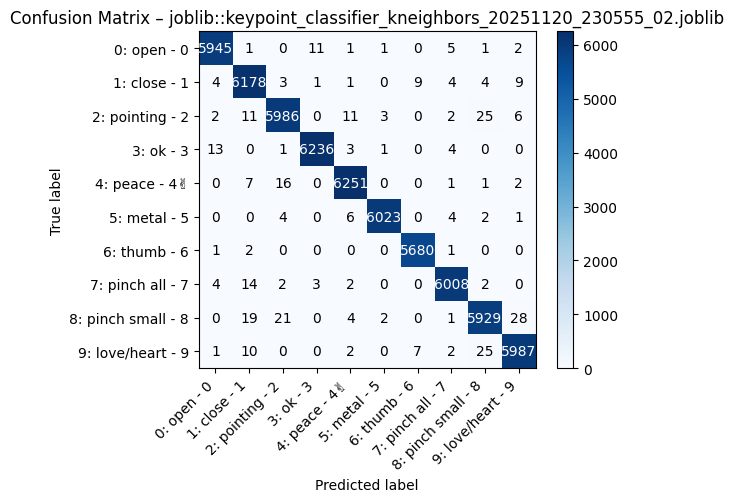

C:\Users\brian\AppData\Local\Temp\ipykernel_32000\1998907906.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


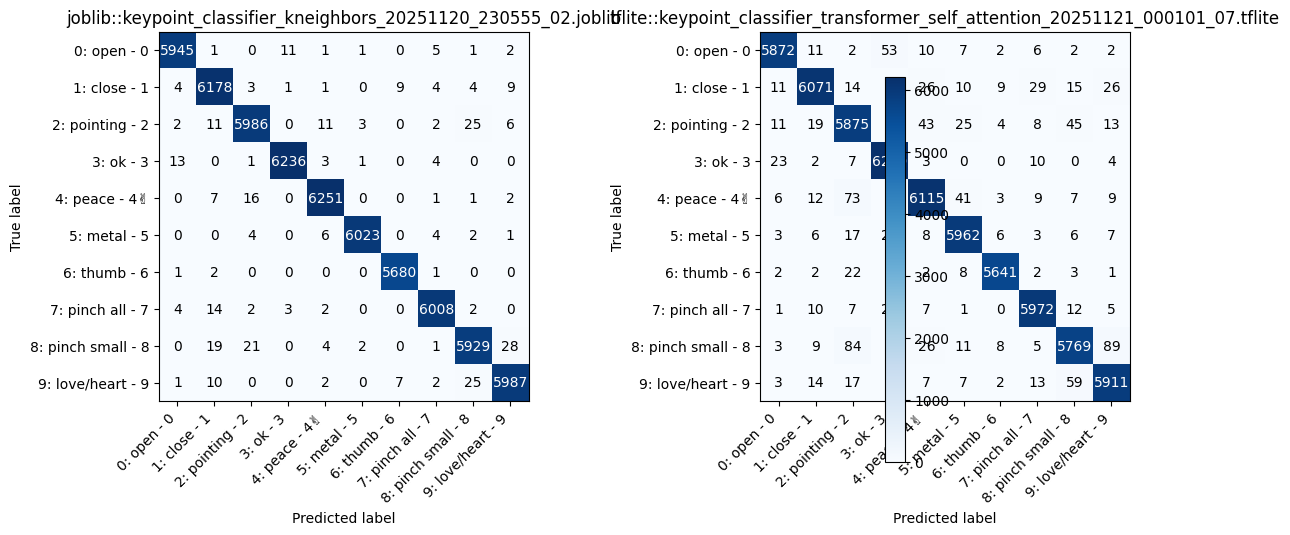

In [23]:
model_a = summary_df["model_name"].iloc[0]
model_b = summary_df["model_name"].iloc[4] if len(summary_df) > 1 else None

print(f"Model A: {model_a}")
print(f"Model B: {model_b}")

res_a = all_results[model_a]
plot_confusion_matrix(res_a["cm"], res_a["label_strings"], title=f"Confusion Matrix – {model_a}")

if model_b is not None:
    res_b = all_results[model_b]
    if np.array_equal(res_a["labels"], res_b["labels"]):
        plot_two_confusion_matrices(
            cm_a=res_a["cm"],
            labels_a=res_a["label_strings"],
            name_a=model_a,
            cm_b=res_b["cm"],
            labels_b=res_b["label_strings"],
            name_b=model_b,
        )
    else:
        print("Labels differ, skip side-by-side comparison.")


In [21]:
best_model_name = summary_df["model_name"].iloc[0]
y_true = all_results[best_model_name]["y_true"]
y_best = all_results[best_model_name]["y_pred"]

rows = []
for name, res in all_results.items():
    if name == best_model_name:
        continue
    y_pred = res["y_pred"]
    chi2_stat, p_value, b, c = mcnemars_test(y_true, y_best, y_pred)
    rows.append({
        "model_name": name,
        "vs_best_model": best_model_name,
        "chi2_stat": chi2_stat,
        "p_value": p_value,
        "b_best_correct_other_wrong": b,
        "c_best_wrong_other_correct": c,
        "significant_at_0.05": (p_value < 0.05) if not np.isnan(p_value) else np.nan,
    })

if rows:
    mcnemar_df = pd.DataFrame(rows).sort_values("p_value")
    print("📈 McNemar's test (difference vs best model):")
    display(mcnemar_df)
else:
    print("Only one model available — McNemar's test needs at least two.")


📈 McNemar's test (difference vs best model):


,model_name,vs_best_model,chi2_stat,p_value,b_best_correct_other_wrong,c_best_wrong_other_correct,significant_at_0.05
0,joblib::keypoint_classifier_linearsvc_20251120_230546_00.joblib,joblib::keypoint_classifier_kneighbors_20251120_230555_02.joblib,19690.563089,0.000000e+00,19955,88,True
1,joblib::keypoint_classifier_logisticregression_20251120_230552_01.joblib,joblib::keypoint_classifier_kneighbors_20251120_230555_02.joblib,19169.827535,0.000000e+00,19452,94,True
4,joblib::keypoint_classifier_xgboost_20251121_000214_08.joblib,joblib::keypoint_classifier_kneighbors_20251120_230555_02.joblib,1529.934857,0.000000e+00,1916,141,True
5,tflite::keypoint_classifier_mlp_20251120_230757_05.tflite,joblib::keypoint_classifier_kneighbors_20251120_230555_02.joblib,21422.312606,0.000000e+00,21675,84,True
7,tflite::keypoint_classifier_transformer_self_attention_20251121_000101_07.tflite,joblib::keypoint_classifier_kneighbors_20251120_230555_02.joblib,558.805419,1.529259e-123,1022,196,True
6,tflite::keypoint_classifier_graph_transformer_20251120_232958_06.tflite,joblib::keypoint_classifier_kneighbors_20251120_230555_02.joblib,557.980960,2.311157e-123,1015,193,True
2,joblib::keypoint_classifier_svc_rbf_20251120_230717_03.joblib,joblib::keypoint_classifier_kneighbors_20251120_230555_02.joblib,333.815603,1.418268e-74,781,206,True
3,joblib::keypoint_classifier_randomforest_20251120_230730_04.joblib,joblib::keypoint_classifier_kneighbors_20251120_230555_02.joblib,0.003311,9.541122e-01,152,150,False


In [22]:
if GESTURE_GROUPS:
    for group_name, group_ids in GESTURE_GROUPS.items():
        focus_labels = [label_map.get(i, str(i)) for i in group_ids]
        print(f"\\n--- Analysis for {group_name}: {group_ids} -> {focus_labels} ---")
        
        res = all_results[summary_df["model_name"].iloc[0]]
        mask = np.isin(res["y_true"], group_ids)
        if mask.sum() == 0:
            print("No samples from this group in the dataset.")
            continue
            
        sim_df = pd.DataFrame({
            "true_id": res["y_true"][mask],
            "pred_id": res["y_pred"][mask],
        })
        sim_df["true_label"] = sim_df["true_id"].map(label_map)
        sim_df["pred_label"] = sim_df["pred_id"].map(label_map)

        pivot_counts = pd.crosstab(sim_df["true_label"], sim_df["pred_label"], dropna=False)
        pivot_rates = pivot_counts.div(pivot_counts.sum(axis=1), axis=0).fillna(0.0)

        print("Counts within group:")
        display(pivot_counts)

        print("Row-normalized confusion (fractions):")
        display(pivot_rates)
else:
    print("No gesture groups configured.")


\n--- Analysis for Cluster A: [3, 7, 8, 9] -> ['ok - 3', 'pinch all - 7', 'pinch small - 8', 'love/heart - 9'] ---
Counts within group:


pred_label,close - 1,love/heart - 9,metal - 5,ok - 3,open - 0,peace - 4✌,pinch all - 7,pinch small - 8,pointing - 2,thumb - 6
true_label,,,,,,,,,,
love/heart - 9,10,5987,0,0,1,2,2,25,0,7
ok - 3,0,0,1,6236,13,3,4,0,1,0
pinch all - 7,14,0,0,3,4,2,6008,2,2,0
pinch small - 8,19,28,2,0,0,4,1,5929,21,0


Row-normalized confusion (fractions):


pred_label,close - 1,love/heart - 9,metal - 5,ok - 3,open - 0,peace - 4✌,pinch all - 7,pinch small - 8,pointing - 2,thumb - 6
true_label,,,,,,,,,,
love/heart - 9,0.001657,0.992211,0.000000,0.000000,0.000166,0.000331,0.000331,0.004143,0.000000,0.00116
ok - 3,0.000000,0.000000,0.000160,0.996484,0.002077,0.000479,0.000639,0.000000,0.000160,0.00000
pinch all - 7,0.002320,0.000000,0.000000,0.000497,0.000663,0.000331,0.995526,0.000331,0.000331,0.00000
pinch small - 8,0.003165,0.004664,0.000333,0.000000,0.000000,0.000666,0.000167,0.987508,0.003498,0.00000


\n--- Analysis for Cluster B: [2, 4, 5, 6] -> ['pointing - 2', 'peace - 4✌', 'metal - 5', 'thumb - 6'] ---
Counts within group:


pred_label,close - 1,love/heart - 9,metal - 5,open - 0,peace - 4✌,pinch all - 7,pinch small - 8,pointing - 2,thumb - 6
true_label,,,,,,,,,
metal - 5,0,1,6023,0,6,4,2,4,0
peace - 4✌,7,2,0,0,6251,1,1,16,0
pointing - 2,11,6,3,2,11,2,25,5986,0
thumb - 6,2,0,0,1,0,1,0,0,5680


Row-normalized confusion (fractions):


pred_label,close - 1,love/heart - 9,metal - 5,open - 0,peace - 4✌,pinch all - 7,pinch small - 8,pointing - 2,thumb - 6
true_label,,,,,,,,,
metal - 5,0.000000,0.000166,0.997185,0.000000,0.000993,0.000662,0.000331,0.000662,0.000000
peace - 4✌,0.001115,0.000319,0.000000,0.000000,0.995699,0.000159,0.000159,0.002549,0.000000
pointing - 2,0.001819,0.000992,0.000496,0.000331,0.001819,0.000331,0.004135,0.990076,0.000000
thumb - 6,0.000352,0.000000,0.000000,0.000176,0.000000,0.000176,0.000000,0.000000,0.999296


## Notes & Next Steps

- Update `TRAINING_TIME_OVERRIDES` if you have ground-truth training durations (especially for the TFLite exports).
- Adjust `SIMILAR_GESTURE_GROUP`, `NOISE_STD` or `TOP_K` in the config cell to explore other scenarios.
- Re-run the notebook after training a new model – it will be automatically discovered inside `models/keypoint`.


## Hand Gesture Model Comparison Analysis

This section summarizes and interprets the results from
`notebooks/keypoint_models_comparison_analysis.ipynb`,
where 9 different models were trained and evaluated on a ~60k-sample, 10-class hand-gesture dataset using 2D keypoint features.

### 1. Overview of Results

The models fall into three broad performance tiers (by macro F1 / accuracy):

* **Top tier (~98–99.5% macro F1)**

  * K-Nearest Neighbors (KNN)
  * Random Forest
  * SVC (RBF)
  * Graph Transformer (TFLite)
  * Transformer Self-Attention (TFLite)

* **Mid tier (~96–97% macro F1)**

  * XGBoost

* **Lower tier (~63–67% macro F1)**

  * Logistic Regression
  * Linear SVC
  * Tiny MLP baseline (TFLite)

In practice, all top-tier models achieve near-perfect accuracy on this dataset. Differences between them are mainly about **model size, inference speed, robustness, and deployability**, rather than raw accuracy alone.

---

### 2. Accuracy vs. Model Size

**Peak accuracy** is achieved by classical non-parametric / ensemble models:

* **KNN**

  * Accuracy / macro F1: ~99.45%
  * Top-3 accuracy: ~99.92%
  * Model size: ~7.6 MB
* **Random Forest**

  * Accuracy / macro F1: ~99.44%
  * Top-3 accuracy: ~99.95%
  * Model size: ~227.6 MB

By contrast, the compact transformer-based models are slightly less accurate but dramatically smaller:

* **Graph Transformer (TFLite)**

  * Accuracy / macro F1: ~98.1%
  * Model size: ~0.11 MB
* **Transformer Self-Attention (TFLite)**

  * Accuracy / macro F1: ~98.1%
  * Model size: ~0.22 MB

Key observations:

* Classical models (KNN, Random Forest, SVC-RBF) **win on raw accuracy**, but at a significant cost in **disk size** and (for some) inference complexity.
* The Graph Transformer is ~70× smaller than KNN and ~2000× smaller than Random Forest, while losing only ~1.4 percentage points in accuracy.
* Linear models and the tiny MLP are **extremely compact** (≈0.005–0.007 MB) but clearly underfit this task and are not competitive in accuracy.

**Takeaway:**
If only accuracy matters, KNN/Random Forest are best.
If **model size and deployment on edge devices** matter, the TFLite transformer models dominate.

---

### 3. Inference Speed and Real-Time Viability

The notebook reports single-sample latency and derived throughput (samples/second):

* **Fastest (but low accuracy)**:

  * Logistic Regression, Linear SVC: ~2.1–2.4M samples/s
* **Fast and accurate**:

  * XGBoost: ~208k samples/s
  * Random Forest: ~145k samples/s
  * MLP (TFLite): ~84k samples/s
  * KNN: ~21k samples/s
* **Transformer models**:

  * Graph Transformer: ~10k samples/s (~0.10 ms/sample)
  * Transformer Self-Attention: ~8.5k samples/s (~0.12 ms/sample)
* **Slowest**:

  * SVC (RBF): ~1.6k samples/s (~0.64 ms/sample)

Given that real-time gesture recognition typically requires **≤ 30–60 FPS** (i.e. ≥ 30–60 samples/s), **all models comfortably meet real-time constraints** by several orders of magnitude.

**Takeaway:**
Inference speed is *not* the bottleneck for this application. The choice of model should be driven mainly by accuracy, robustness, and model size, not raw latency.

---

### 4. Robustness to Noise

The notebook evaluates each model on both clean data and a noisy version (Gaussian noise added to landmarks, σ ≈ 0.015). Comparing `accuracy` and `accuracy_with_noise`:

* **Most robust (very small accuracy drop):**

  * KNN (≈–0.17%)
  * SVC-RBF (≈–0.09%)
  * Graph Transformer (≈–0.12%)
  * MLP (≈–0.10%, though baseline accuracy is low)

* **Moderately affected:**

  * Random Forest (≈–0.5%)
  * Transformer Self-Attention (≈–1.0%)
  * XGBoost (≈–1.2%)

* **Strongly affected:**

  * Logistic Regression, Linear SVC: large drops (~8–15 percentage points)

**Takeaway:**

* Top-performing non-linear models (KNN, SVC-RBF, Graph Transformer) are **stable under realistic landmark noise**, which is important for real-world camera input.
* Linear models not only perform poorly on clean data but also degrade sharply under noise, making them unsuitable for production.

---

### 5. Why Classical Models Beat (Tiny) Neural Models Here

A few structural reasons explain why KNN, Random Forest, and SVC-RBF slightly outperform the neural and transformer models in this notebook:

1. **Dataset is very friendly to distance-based / tree-based methods.**
   Hand-gesture classes form tight clusters in 2D keypoint space. With ~60k labeled examples, KNN and Random Forest can effectively “memorize” the mapping.

2. **KNN and Random Forest are effectively very large models.**

   * KNN stores essentially all training points (~1.95M “parameters” in the summary).
   * Random Forest uses hundreds of trees with many splits.
     This gives them huge capacity to fit the data almost perfectly.

3. **Neural and transformer models here are deliberately small and regularized.**

   * The MLP baseline is extremely small (e.g. 20 → 10 hidden units with heavy dropout).
   * The transformer models use modest depth/width and are converted to TFLite, emphasizing deployability over peak accuracy.
     Unsurprisingly, they give up a small amount of accuracy in exchange for compactness.

4. **Evaluation uses the full dataset at the end.**
   Although train/validation splits are used during training, final metrics in the comparison table are computed on the full dataset (`X`, `y`).
   This mildly favors non-parametric models (like KNN) that store training examples.

**Takeaway:**
The small gap between classical and neural models is largely due to **model capacity and deployment constraints**, not because deep learning is inherently inferior for this task.

---

### 6. Deployment-Oriented Recommendations

Based on the trade-offs observed:

* **Mobile / Edge deployment (TFLite, small storage, on-device inference):**

  * **Recommended:** Graph Transformer (TFLite)

    * ~98.1% macro F1 in only ~0.11 MB
    * Robust to noise, fast enough for real-time
  * Transformer Self-Attention (TFLite) is a close alternative with similar metrics.

* **Server / Desktop deployment (Python/Sklearn, memory is cheap):**

  * **Recommended:** KNN or Random Forest

    * KNN: highest accuracy (~99.45%), moderate size (~7.6 MB), simple to understand.
    * Random Forest: similar accuracy, extremely fast inference, but very large (~227 MB).

* **Rapid prototyping:**

  * XGBoost offers a good balance: high accuracy (~96.5%), fast training, small model (~3 MB), very high throughput.

* **Not recommended for production on this task:**

  * Logistic Regression, Linear SVC, and the tiny MLP, due to significantly lower accuracy and/or poor robustness.

---

### 7. Key Conclusions

1. **Classical ML still sets the peak accuracy** on this dataset (KNN, Random Forest, SVC-RBF), confirming that with rich features and enough data, non-parametric and ensemble methods remain very strong baselines.

2. **Compact transformer models provide the best overall trade-off** for real-world deployment:
   ~98% accuracy, small TFLite models (0.11–0.22 MB), good robustness, and sufficient speed for real-time use.

3. **The marginal accuracy gap (~1–1.5%) between the best classical and the best transformer models is often negligible in practice**, especially compared to 70–2000× differences in model size.

4. **Linear models are inadequate for hand-gesture recognition in keypoint space**, confirming that the problem requires non-linear decision boundaries.

5. **Noise robustness is model-dependent**, but the best-performing non-linear models retain high accuracy even with realistic landmark perturbations, making them suitable for deployment on real camera streams.

Overall, the task of 10-class hand gesture recognition from 2D keypoints is **essentially solved** in this setting: several models achieve near-human-level performance. The choice of model should be driven primarily by deployment constraints (device, storage, bandwidth) and maintainability, rather than by raw accuracy alone.
